In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Parameter Setting
----------------------

In [9]:
def _map_freq(freq):

    if freq == '1m':
        horizon = 21
    elif freq == '1w':
        horizon = 4
    elif freq == '2w':
        horizon = 8
    elif freq == '3w':
        horizon = 12
    elif freq == '1d':
        horizon = 0
    else:
        raise ValueError("Unrecognized freq: {0}".format(freq))
    return horizon

In [215]:
alpha_factors = {
    'eps': LAST('eps_q'),
    'roe': LAST('roe_q'),
    'bdto': LAST('BDTO'),
    'cfinc1': LAST('CFinc1'),
    'chv': LAST('CHV'),
    'rvol': LAST('RVOL'),
    'val': LAST('VAL'),
    'grev': LAST('GREV'),
    'droeafternonorecurring': LAST('DROEAfterNonRecurring')
}
engine = SqlEngine()
universe = Universe('custom', ['zz500'])
benchmark_code = 905
neutralize_risk = ['SIZE'] + industry_styles
constraint_risk = ['SIZE'] + industry_styles
start_date = '2012-01-01'
end_date = '2017-11-02'
industry_lower = 1.
industry_upper = 1.

freq = '2w'
batch = 8

In [216]:
data_package = fetch_data_package(engine,
                                  alpha_factors=alpha_factors,
                                  start_date=start_date,
                                  end_date=end_date,
                                  frequency=freq,
                                  universe=universe,
                                  benchmark=benchmark_code,
                                  batch=batch,
                                  neutralized_risk=neutralize_risk,
                                  pre_process=[winsorize_normal],
                                  post_process=[winsorize_normal],
                                  warm_start=batch)

2017-11-06 15:50:00,321 - ALPHA_MIND - INFO - Starting data package fetching ...
2017-11-06 15:50:14,655 - ALPHA_MIND - INFO - Loading data is finished
2017-11-06 15:50:15,783 - ALPHA_MIND - INFO - Data processing is finished


In [217]:
train_x = data_package['train']['x']
train_y = data_package['train']['y']

predict_x = data_package['predict']['x']
predict_y = data_package['predict']['y']

settlement = data_package['settlement']
features = data_package['x_names']

# Naive Executor Strategy
---------------------------------

In [218]:
dates = sorted(train_x.keys())
model_df = pd.Series()
horizon = _map_freq(freq)

rets = []
turn_overs = []
executor = NaiveExecutor()
leverags = []

for i, ref_date in enumerate(dates):
    
    # Model Training and Prediction
    
    sample_train_x = train_x[ref_date]
    sample_train_y = train_y[ref_date].flatten()
    
    model = LinearRegression()
    model.fit(sample_train_x, sample_train_y)
    
    sample_test_x = predict_x[ref_date]
    sample_test_y = predict_y[ref_date].flatten()
    
    er = model.predict(sample_test_x)
    model_df.loc[ref_date] = model
    
    # Constraints Building #
    
    today_settlement = settlement[settlement.trade_date == ref_date]
    codes = today_settlement.code.tolist()
    
    dx_return = None
    risk_exp = today_settlement[neutralize_risk].values.astype(float)
    industry = today_settlement.industry.values
    benchmark_w = today_settlement.weight.values
    
    constraint_exp = today_settlement[constraint_risk].values
    risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)
    risk_names = constraint_risk + ['total']
    risk_target = risk_exp_expand.T @ benchmark_w
    lbound = np.zeros(len(today_settlement))
    ubound = 0.01 + benchmark_w

    constraint = Constraints(risk_exp_expand, risk_names)
    for i, name in enumerate(risk_names):
        if name == 'total' or name == 'SIZE':
            constraint.set_constraints(name, lower_bound=risk_target[i], upper_bound=risk_target[i])
        else:
            constraint.set_constraints(name, lower_bound=risk_target[i]*industry_lower, upper_bound=risk_target[i]*industry_upper)
    
    target_pos, _ = er_portfolio_analysis(er,
                                          industry,
                                          dx_return,
                                          constraint,
                                          False,
                                          benchmark_w)
    
    target_pos['code'] = today_settlement['code'].values
    
    turn_over, executed_pos = executor.execute(target_pos=target_pos)
    
    executed_codes = executed_pos.code.tolist()
    dx_retuns = engine.fetch_dx_return(ref_date.strftime('%Y-%m-%d'), executed_codes, horizon=horizon)
    
    result = pd.merge(executed_pos, today_settlement[['code', 'weight']], on=['code'], how='inner')
    result = pd.merge(result, dx_retuns, on=['code'])
    
    leverage = result.weight_x.abs().sum()
    
    ret = (result.weight_x - result.weight_y * leverage / result.weight_y.sum()).values @ result.dx.values
    rets.append(ret)
    executor.set_current(executed_pos)
    turn_overs.append(turn_over)
    leverags.append(leverage)
    print('{0} is finished'.format(ref_date))

2012-02-02 00:00:00 is finished
2012-02-16 00:00:00 is finished
2012-03-01 00:00:00 is finished
2012-03-15 00:00:00 is finished
2012-03-29 00:00:00 is finished
2012-04-12 00:00:00 is finished
2012-04-26 00:00:00 is finished
2012-05-10 00:00:00 is finished
2012-05-24 00:00:00 is finished
2012-06-07 00:00:00 is finished
2012-06-21 00:00:00 is finished
2012-07-05 00:00:00 is finished
2012-07-19 00:00:00 is finished
2012-08-02 00:00:00 is finished
2012-08-16 00:00:00 is finished
2012-08-30 00:00:00 is finished
2012-09-13 00:00:00 is finished
2012-09-27 00:00:00 is finished
2012-10-11 00:00:00 is finished
2012-10-25 00:00:00 is finished
2012-11-08 00:00:00 is finished
2012-11-22 00:00:00 is finished
2012-12-06 00:00:00 is finished
2012-12-20 00:00:00 is finished
2013-01-04 00:00:00 is finished
2013-01-17 00:00:00 is finished
2013-01-31 00:00:00 is finished
2013-02-18 00:00:00 is finished
2013-02-28 00:00:00 is finished
2013-03-14 00:00:00 is finished
2013-03-28 00:00:00 is finished
2013-04-

In [219]:
ret_df1 = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverage}, index=dates)
ret_df1.loc[advanceDateByCalendar('china.sse', dates[-1], freq)] = 0.
ret_df1 = ret_df1.shift(1)
ret_df1.iloc[0] = 0.
ret_df1['tc_cost'] = ret_df1.turn_over * 0.002

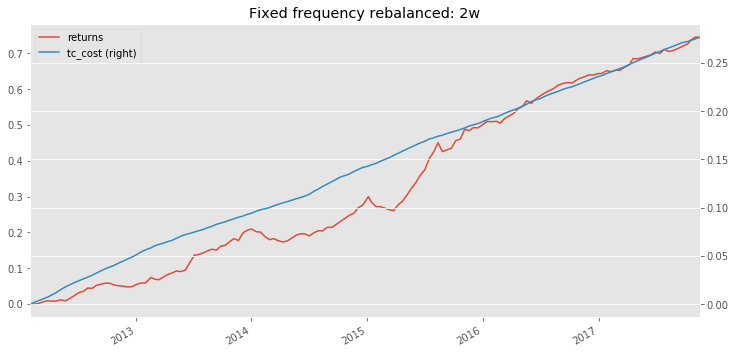

In [220]:
ret_df1[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6), title='Fixed frequency rebalanced: {0}'.format(freq), secondary_y='tc_cost')

In [221]:
ret_atfer_tc = ret_df1.returns - ret_df1.tc_cost
print("sharp: ", ret_atfer_tc.mean() / ret_atfer_tc.std() * np.sqrt(52))

sharp:  2.72204351054


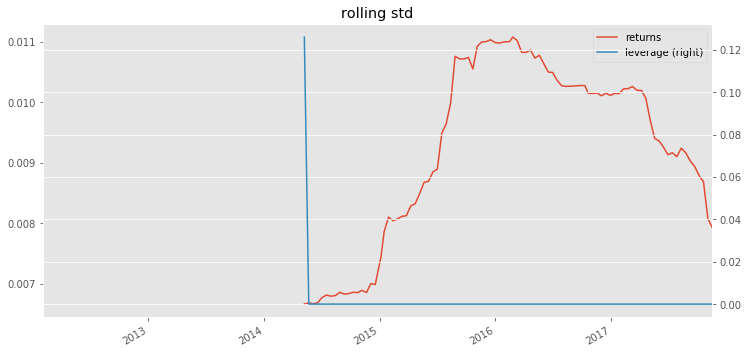

In [222]:
ret_df1[['returns', 'leverage']].rolling(window=60).std().plot(figsize=(12, 6), title='rolling std', secondary_y='leverage')

# Threshold Turn Over + Strategy
------------------------------------

In [223]:
freq = '1d'
horizon = _map_freq(freq)
dates = makeSchedule(start_date, end_date, tenor=freq, calendar='china.sse', dateGenerationRule=DateGeneration.Backward)

In [224]:
all_data = engine.fetch_data_range(universe, alpha_factors, dates=dates, benchmark=905)
factor_all_data = all_data['factor']
factor_groups = factor_all_data.groupby('trade_date')

In [225]:
rets = []
turn_overs = []
turn_over_threshold = 0.90
executor = ThresholdExecutor(turn_over_threshold=turn_over_threshold)
execution_pipeline = ExecutionPipeline(executors=[executor])
leverags = []
execution_dates = []
horizon = _map_freq(freq)

for i, value in enumerate(factor_groups):
    
    date = value[0]
    data = value[1]
    
    # get the latest model
    models = model_df[model_df.index <= date]
    
    if models.empty:
        continue
    
    execution_dates.append(date)
    model = models[-1]
    
    codes = data.code.tolist()
    ref_date = date.strftime('%Y-%m-%d')
    total_data = data.dropna()
    dx_return = None
    risk_exp = total_data[neutralize_risk].values.astype(float)
    industry = total_data.industry.values
    benchmark_w = total_data.weight.values
    
    constraint_exp = total_data[constraint_risk].values
    risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)
    risk_names = constraint_risk + ['total']
    risk_target = risk_exp_expand.T @ benchmark_w
    lbound = np.zeros(len(total_data))
    ubound = 0.01 + benchmark_w

    constraint = Constraints(risk_exp_expand, risk_names)
    for i, name in enumerate(risk_names):
        if name == 'total' or name == 'SIZE':
            constraint.set_constraints(name, lower_bound=risk_target[i], upper_bound=risk_target[i])
        else:
            constraint.set_constraints(name, lower_bound=risk_target[i]*industry_lower, upper_bound=risk_target[i]*industry_upper)
            
    
    factors_values = factor_processing(total_data[features].values,
                                       pre_process=[winsorize_normal],
                                       post_process=[winsorize_normal])

    er = model.predict(factors_values)
    
    target_pos, _ = er_portfolio_analysis(er,
                                          industry,
                                          dx_return,
                                          constraint,
                                          False,
                                          benchmark_w)
    
    target_pos['code'] = total_data['code'].values
    
    turn_over, executed_pos = execution_pipeline.execute(target_pos=target_pos)
    
    executed_codes = executed_pos.code.tolist()
    dx_retuns = engine.fetch_dx_return(date, executed_codes, horizon=horizon)
    
    result = pd.merge(executed_pos, total_data, on=['code'], how='inner')
    result = pd.merge(result, dx_retuns, on=['code'])
    leverage = result.weight_x.abs().sum()
    
    ret = (result.weight_x - result.weight_y * leverage / result.weight_y.sum()).values @ result.dx.values
    rets.append(ret)
    leverags.append(executed_pos.weight.abs().sum())
    turn_overs.append(turn_over)
    print('{0} is finished: {1}'.format(date, turn_over))

2012-02-02 00:00:00 is finished: 0.9763
2012-02-03 00:00:00 is finished: 0.0
2012-02-06 00:00:00 is finished: 0.0
2012-02-07 00:00:00 is finished: 0.0
2012-02-08 00:00:00 is finished: 0.0
2012-02-09 00:00:00 is finished: 0.0
2012-02-10 00:00:00 is finished: 0.0
2012-02-13 00:00:00 is finished: 0.9309219332698693
2012-02-14 00:00:00 is finished: 0.0
2012-02-15 00:00:00 is finished: 0.0
2012-02-16 00:00:00 is finished: 0.0
2012-02-17 00:00:00 is finished: 0.0
2012-02-20 00:00:00 is finished: 0.0
2012-02-21 00:00:00 is finished: 0.0
2012-02-22 00:00:00 is finished: 0.9004128902190728
2012-02-23 00:00:00 is finished: 0.0
2012-02-24 00:00:00 is finished: 0.0
2012-02-27 00:00:00 is finished: 0.0
2012-02-28 00:00:00 is finished: 0.0
2012-02-29 00:00:00 is finished: 0.9316366577185158
2012-03-01 00:00:00 is finished: 0.0
2012-03-02 00:00:00 is finished: 0.0
2012-03-05 00:00:00 is finished: 0.0
2012-03-06 00:00:00 is finished: 0.0
2012-03-07 00:00:00 is finished: 0.0
2012-03-08 00:00:00 is fini

2012-12-11 00:00:00 is finished: 0.0
2012-12-12 00:00:00 is finished: 0.0
2012-12-13 00:00:00 is finished: 0.0
2012-12-14 00:00:00 is finished: 0.0
2012-12-17 00:00:00 is finished: 0.0
2012-12-18 00:00:00 is finished: 0.0
2012-12-19 00:00:00 is finished: 0.0
2012-12-20 00:00:00 is finished: 1.1935
2012-12-21 00:00:00 is finished: 0.0
2012-12-24 00:00:00 is finished: 0.0
2012-12-25 00:00:00 is finished: 0.0
2012-12-26 00:00:00 is finished: 0.8609016393442623
2012-12-27 00:00:00 is finished: 0.0
2012-12-28 00:00:00 is finished: 0.0
2012-12-31 00:00:00 is finished: 0.0
2013-01-04 00:00:00 is finished: 1.0128983606557378
2013-01-07 00:00:00 is finished: 0.0
2013-01-08 00:00:00 is finished: 0.0
2013-01-09 00:00:00 is finished: 0.0
2013-01-10 00:00:00 is finished: 1.0442987760097924
2013-01-11 00:00:00 is finished: 0.0
2013-01-14 00:00:00 is finished: 0.0
2013-01-15 00:00:00 is finished: 0.0
2013-01-16 00:00:00 is finished: 0.905
2013-01-17 00:00:00 is finished: 0.0
2013-01-18 00:00:00 is fi

2013-11-08 00:00:00 is finished: 0.0
2013-11-11 00:00:00 is finished: 0.0
2013-11-12 00:00:00 is finished: 0.0
2013-11-13 00:00:00 is finished: 0.0
2013-11-14 00:00:00 is finished: 0.0
2013-11-15 00:00:00 is finished: 0.0
2013-11-18 00:00:00 is finished: 0.0
2013-11-19 00:00:00 is finished: 0.0
2013-11-20 00:00:00 is finished: 0.0
2013-11-21 00:00:00 is finished: 0.9407000000000001
2013-11-22 00:00:00 is finished: 0.0
2013-11-25 00:00:00 is finished: 0.0
2013-11-26 00:00:00 is finished: 0.0
2013-11-27 00:00:00 is finished: 0.0
2013-11-28 00:00:00 is finished: 0.0
2013-11-29 00:00:00 is finished: 0.0
2013-12-02 00:00:00 is finished: 0.0
2013-12-03 00:00:00 is finished: 0.0
2013-12-04 00:00:00 is finished: 0.0
2013-12-05 00:00:00 is finished: 0.8748959468725963
2013-12-06 00:00:00 is finished: 0.0
2013-12-09 00:00:00 is finished: 0.0
2013-12-10 00:00:00 is finished: 0.0
2013-12-11 00:00:00 is finished: 0.0
2013-12-12 00:00:00 is finished: 0.0
2013-12-13 00:00:00 is finished: 0.0
2013-12-

2014-09-22 00:00:00 is finished: 0.0
2014-09-23 00:00:00 is finished: 0.9485193292144749
2014-09-24 00:00:00 is finished: 0.0
2014-09-25 00:00:00 is finished: 0.861946043560289
2014-09-26 00:00:00 is finished: 0.0
2014-09-29 00:00:00 is finished: 0.0
2014-09-30 00:00:00 is finished: 0.0
2014-10-08 00:00:00 is finished: 0.0
2014-10-09 00:00:00 is finished: 0.0
2014-10-10 00:00:00 is finished: 0.0
2014-10-13 00:00:00 is finished: 0.0
2014-10-14 00:00:00 is finished: 0.0
2014-10-15 00:00:00 is finished: 0.8469732856541858
2014-10-16 00:00:00 is finished: 0.0
2014-10-17 00:00:00 is finished: 0.0
2014-10-20 00:00:00 is finished: 0.0
2014-10-21 00:00:00 is finished: 0.0
2014-10-22 00:00:00 is finished: 0.0
2014-10-23 00:00:00 is finished: 0.0
2014-10-24 00:00:00 is finished: 0.0
2014-10-27 00:00:00 is finished: 0.0
2014-10-28 00:00:00 is finished: 0.9443706960726671
2014-10-29 00:00:00 is finished: 0.0
2014-10-30 00:00:00 is finished: 0.0
2014-10-31 00:00:00 is finished: 0.0
2014-11-03 00:00

2015-08-05 00:00:00 is finished: 0.0
2015-08-06 00:00:00 is finished: 0.86401
2015-08-07 00:00:00 is finished: 0.0
2015-08-10 00:00:00 is finished: 0.0
2015-08-11 00:00:00 is finished: 0.0
2015-08-12 00:00:00 is finished: 0.0
2015-08-13 00:00:00 is finished: 0.0
2015-08-14 00:00:00 is finished: 0.0
2015-08-17 00:00:00 is finished: 0.0
2015-08-18 00:00:00 is finished: 0.0
2015-08-19 00:00:00 is finished: 0.0
2015-08-20 00:00:00 is finished: 0.0
2015-08-21 00:00:00 is finished: 0.0
2015-08-24 00:00:00 is finished: 0.0
2015-08-25 00:00:00 is finished: 0.0
2015-08-26 00:00:00 is finished: 0.0
2015-08-27 00:00:00 is finished: 0.89478
2015-08-28 00:00:00 is finished: 0.0
2015-08-31 00:00:00 is finished: 0.0
2015-09-01 00:00:00 is finished: 0.0
2015-09-02 00:00:00 is finished: 0.0
2015-09-07 00:00:00 is finished: 0.0
2015-09-08 00:00:00 is finished: 0.0
2015-09-09 00:00:00 is finished: 0.0
2015-09-10 00:00:00 is finished: 0.0
2015-09-11 00:00:00 is finished: 0.0
2015-09-14 00:00:00 is finishe

2016-06-27 00:00:00 is finished: 0.0
2016-06-28 00:00:00 is finished: 0.0
2016-06-29 00:00:00 is finished: 0.0
2016-06-30 00:00:00 is finished: 1.0311508086167798
2016-07-01 00:00:00 is finished: 0.0
2016-07-04 00:00:00 is finished: 0.0
2016-07-05 00:00:00 is finished: 0.0
2016-07-06 00:00:00 is finished: 0.0
2016-07-07 00:00:00 is finished: 0.0
2016-07-08 00:00:00 is finished: 0.9323001762114539
2016-07-11 00:00:00 is finished: 0.0
2016-07-12 00:00:00 is finished: 0.0
2016-07-13 00:00:00 is finished: 0.0
2016-07-14 00:00:00 is finished: 0.0
2016-07-15 00:00:00 is finished: 0.0
2016-07-18 00:00:00 is finished: 0.0
2016-07-19 00:00:00 is finished: 0.0
2016-07-20 00:00:00 is finished: 0.8720201762114541
2016-07-21 00:00:00 is finished: 0.0
2016-07-22 00:00:00 is finished: 0.0
2016-07-25 00:00:00 is finished: 0.0
2016-07-26 00:00:00 is finished: 0.0
2016-07-27 00:00:00 is finished: 0.0
2016-07-28 00:00:00 is finished: 0.0
2016-07-29 00:00:00 is finished: 0.8672199999999999
2016-08-01 00:0

2017-05-12 00:00:00 is finished: 0.0
2017-05-15 00:00:00 is finished: 0.0
2017-05-16 00:00:00 is finished: 0.0
2017-05-17 00:00:00 is finished: 0.0
2017-05-18 00:00:00 is finished: 0.0
2017-05-19 00:00:00 is finished: 0.0
2017-05-22 00:00:00 is finished: 0.0
2017-05-23 00:00:00 is finished: 0.0
2017-05-24 00:00:00 is finished: 0.0
2017-05-25 00:00:00 is finished: 0.0
2017-05-26 00:00:00 is finished: 0.0
2017-05-31 00:00:00 is finished: 0.0
2017-06-01 00:00:00 is finished: 0.0
2017-06-02 00:00:00 is finished: 0.0
2017-06-05 00:00:00 is finished: 0.0
2017-06-06 00:00:00 is finished: 0.9212339483870966
2017-06-07 00:00:00 is finished: 0.0
2017-06-08 00:00:00 is finished: 0.0
2017-06-09 00:00:00 is finished: 0.0
2017-06-12 00:00:00 is finished: 0.0
2017-06-13 00:00:00 is finished: 0.0
2017-06-14 00:00:00 is finished: 0.97331
2017-06-15 00:00:00 is finished: 0.0
2017-06-16 00:00:00 is finished: 0.0
2017-06-19 00:00:00 is finished: 0.0
2017-06-20 00:00:00 is finished: 0.8992600000000001
2017

In [226]:
ret_df2 = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=execution_dates)
ret_df2.loc[advanceDateByCalendar('china.sse', dates[-1], freq)] = 0.
ret_df2 = ret_df2.shift(1)
ret_df2.iloc[0] = 0.
ret_df2['tc_cost'] = ret_df2.turn_over * 0.002

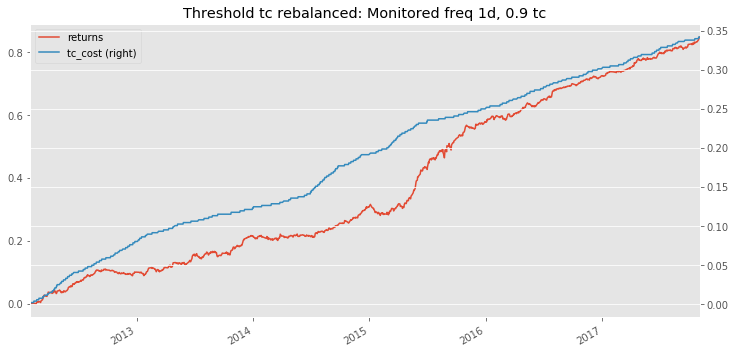

In [227]:
ret_df2[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                             title='Threshold tc rebalanced: Monitored freq {0}, {1} tc'.format(freq,
                                                                                                                turn_over_threshold),
                                             secondary_y='tc_cost')

In [228]:
ret_atfer_tc = ret_df2.returns - ret_df2.tc_cost
print("sharp: ", ret_atfer_tc.mean() / ret_atfer_tc.std() * np.sqrt(252))

sharp:  2.17360434401


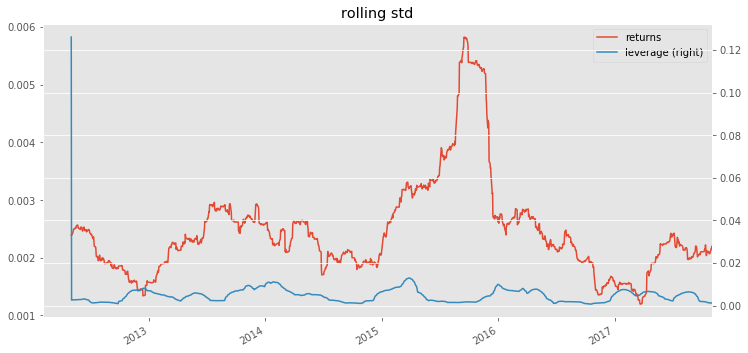

In [229]:
ret_df2[['returns', 'leverage']].rolling(window=60).std().plot(figsize=(12, 6), title='rolling std', secondary_y='leverage')

# Target Vol + Threshold Turn Over + Strategy
------------------------

In [230]:
rets = []
turn_overs = []
target_vol = 0.002
turn_over_threshold = 0.70
window = 30
executor1 = TargetVolExecutor(window=window, target_vol=target_vol)
executor2 = ThresholdExecutor(turn_over_threshold=turn_over_threshold, is_relative=False)
execution_pipeline = ExecutionPipeline(executors=[executor1, executor2])
leverags = []
execution_dates = []
horizon = _map_freq(freq)

for i, value in enumerate(factor_groups):
    date = value[0]
    data = value[1]
    
    # get the latest model
    models = model_df[model_df.index <= date]
    
    if models.empty:
        continue
    
    execution_dates.append(date)
    model = models[-1]
    
    codes = data.code.tolist()
    ref_date = date.strftime('%Y-%m-%d')
    total_data = data.dropna()
    dx_return = None
    risk_exp = total_data[neutralize_risk].values.astype(float)
    industry = total_data.industry.values
    benchmark_w = total_data.weight.values
    
    constraint_exp = total_data[constraint_risk].values
    risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)
    risk_names = constraint_risk + ['total']
    risk_target = risk_exp_expand.T @ benchmark_w
    lbound = np.zeros(len(total_data))
    ubound = 0.01 + benchmark_w

    constraint = Constraints(risk_exp_expand, risk_names)
    for i, name in enumerate(risk_names):
        if name == 'total' or name == 'SIZE':
            constraint.set_constraints(name, lower_bound=risk_target[i], upper_bound=risk_target[i])
        else:
            constraint.set_constraints(name, lower_bound=risk_target[i]*industry_lower, upper_bound=risk_target[i]*industry_upper)
        
    factors_values = factor_processing(total_data[features].values,
                                       pre_process=[winsorize_normal],
                                       post_process=[winsorize_normal])

    er = model.predict(factors_values)
    
    target_pos, _ = er_portfolio_analysis(er,
                                   industry,
                                   dx_return,
                                   constraint,
                                   False,
                                   benchmark_w)
    target_pos['code'] = total_data['code'].values
    
    turn_over, executed_pos = execution_pipeline.execute(target_pos=target_pos)
    
    executed_codes = executed_pos.code.tolist()
    dx_retuns = engine.fetch_dx_return(date, executed_codes, horizon=horizon)
    
    result = pd.merge(executed_pos, total_data, on=['code'], how='inner')
    result = pd.merge(result, dx_retuns, on=['code'])
    
    leverage = result.weight_x.abs().sum()
    
    ret = (result.weight_x - result.weight_y * leverage / result.weight_y.sum()).values @ result.dx.values
    rets.append(ret)
    execution_pipeline.update({'return': ret})
    turn_overs.append(turn_over)
    leverags.append(executed_pos.weight.abs().sum())
    print('{0} is finished: turn_over: {1}, levegare: {2}'.format(date, turn_over, leverags[-1]))

2012-02-02 00:00:00 is finished: turn_over: 0.9763, levegare: 0.9763
2012-02-03 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763
2012-02-06 00:00:00 is finished: turn_over: 0.7380375568528426, levegare: 0.9763000000000001
2012-02-07 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763000000000001
2012-02-08 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763000000000001
2012-02-09 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763000000000001
2012-02-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763000000000001
2012-02-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.9763000000000001
2012-02-14 00:00:00 is finished: turn_over: 0.7806408155822981, levegare: 0.9773999999999999
2012-02-15 00:00:00 is finished: turn_over: 0.0, levegare: 0.9773999999999999
2012-02-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.9773999999999999
2012-02-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.9773999999999999
2012-02-20 00:00:00 is finished: turn_over: 0.0, levega

2012-07-05 00:00:00 is finished: turn_over: 0.8137669817520413, levegare: 0.8791030343662123
2012-07-06 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-09 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-11 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-12 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.8791030343662123
2012-07-16 00:00:00 is finished: turn_over: 0.7252707562801319, levegare: 0.7933191386776727
2012-07-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.7933191386776727
2012-07-18 00:00:00 is finished: turn_over: 0.0, levegare: 0.7933191386776727
2012-07-19 00:00:00 is finished: turn_over: 0.0, levegare: 0.7933191386776727
2012-07-20 00:00:00 is finished: turn_over: 0.0, levegare: 0.7933191386776727
2012-07-23 00:00:00 is finished: t

2012-12-04 00:00:00 is finished: turn_over: 0.7164307402684216, levegare: 0.9672042331659274
2012-12-05 00:00:00 is finished: turn_over: 0.0, levegare: 0.9672042331659274
2012-12-06 00:00:00 is finished: turn_over: 0.0, levegare: 0.9672042331659274
2012-12-07 00:00:00 is finished: turn_over: 0.8694575414830896, levegare: 0.9732938261914718
2012-12-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.9732938261914718
2012-12-11 00:00:00 is finished: turn_over: 0.0, levegare: 0.9732938261914718
2012-12-12 00:00:00 is finished: turn_over: 0.7419234699899061, levegare: 0.9377761852469318
2012-12-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.9377761852469318
2012-12-14 00:00:00 is finished: turn_over: 0.0, levegare: 0.9377761852469318
2012-12-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.9377761852469318
2012-12-18 00:00:00 is finished: turn_over: 0.8601014252786638, levegare: 0.9422033334459542
2012-12-19 00:00:00 is finished: turn_over: 0.0, levegare: 0.9422033334459542
2012

2013-05-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-14 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-15 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-20 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-21 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-22 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-23 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-24 00:00:00 is finished: turn_over: 0.0, levegare: 0.7950546835774224
2013-05-27 00:00:00 is finished: turn_over: 0.7787950479119079, levegare: 0.7489373442082243
2013-05-28 00:00:00 is finished: turn_over: 0.0, levegare: 0.7489373442082243
2013-05-29 00:00:00 is finished: turn_over: 0.0, 

2013-10-23 00:00:00 is finished: turn_over: 0.0, levegare: 0.6282565138506319
2013-10-24 00:00:00 is finished: turn_over: 0.7921315201863984, levegare: 0.6123791595788494
2013-10-25 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-10-28 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-10-29 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-10-30 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-10-31 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-01 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-04 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-05 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-06 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-07 00:00:00 is finished: turn_over: 0.0, levegare: 0.6123791595788494
2013-11-08 00:00:00 is finished: turn_over: 0.0, 

2014-03-28 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-03-31 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-01 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-02 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-03 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-04 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-08 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-09 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-11 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-14 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-15 00:00:00 is finished: turn_over: 0.0, levegare: 0.5863373028528527
2014-04-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.586

2014-08-27 00:00:00 is finished: turn_over: 0.0, levegare: 0.9234732778706698
2014-08-28 00:00:00 is finished: turn_over: 0.7278919500770054, levegare: 0.8954417765196403
2014-08-29 00:00:00 is finished: turn_over: 0.0, levegare: 0.8954417765196403
2014-09-01 00:00:00 is finished: turn_over: 0.0, levegare: 0.8954417765196403
2014-09-02 00:00:00 is finished: turn_over: 0.0, levegare: 0.8954417765196403
2014-09-03 00:00:00 is finished: turn_over: 0.8496568081278273, levegare: 0.9312475190712631
2014-09-04 00:00:00 is finished: turn_over: 0.0, levegare: 0.9312475190712631
2014-09-05 00:00:00 is finished: turn_over: 0.0, levegare: 0.9312475190712631
2014-09-09 00:00:00 is finished: turn_over: 0.7674715046921038, levegare: 0.9831466198970189
2014-09-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.9831466198970189
2014-09-11 00:00:00 is finished: turn_over: 0.7401535434291491, levegare: 0.9806596935939791
2014-09-12 00:00:00 is finished: turn_over: 0.0, levegare: 0.9806596935939791
2014

2015-01-30 00:00:00 is finished: turn_over: 0.7243599402133383, levegare: 0.4645987344545907
2015-02-02 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-03 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-04 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-05 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-06 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-09 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-11 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-12 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.4645987344545907
2015-02-17 00:00:00 is finished: turn_over: 0.0, 

2015-07-07 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-08 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-09 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-10 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-13 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-14 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-15 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-20 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-21 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-22 00:00:00 is finished: turn_over: 0.0, levegare: 0.5532439921539603
2015-07-23 00:00:00 is finished: turn_over: 0.0, levegare: 0.553

2015-12-11 00:00:00 is finished: turn_over: 0.0, levegare: 0.6608904902410107
2015-12-14 00:00:00 is finished: turn_over: 0.0, levegare: 0.6608904902410107
2015-12-15 00:00:00 is finished: turn_over: 0.0, levegare: 0.6608904902410107
2015-12-16 00:00:00 is finished: turn_over: 0.0, levegare: 0.6608904902410107
2015-12-17 00:00:00 is finished: turn_over: 0.0, levegare: 0.6608904902410107
2015-12-18 00:00:00 is finished: turn_over: 0.7385049825540119, levegare: 0.6936574095728247
2015-12-21 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-22 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-23 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-24 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-25 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-28 00:00:00 is finished: turn_over: 0.0, levegare: 0.6936574095728247
2015-12-29 00:00:00 is finished: turn_over: 0.0, 

2016-05-19 00:00:00 is finished: turn_over: 1.1378897185402765, levegare: 0.858403949946159
2016-05-20 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-23 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-24 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-25 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-26 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-27 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-30 00:00:00 is finished: turn_over: 0.0, levegare: 0.858403949946159
2016-05-31 00:00:00 is finished: turn_over: 0.7309772704532823, levegare: 0.8180605242832917
2016-06-01 00:00:00 is finished: turn_over: 0.0, levegare: 0.8180605242832917
2016-06-02 00:00:00 is finished: turn_over: 0.0, levegare: 0.8180605242832917
2016-06-03 00:00:00 is finished: turn_over: 0.0, levegare: 0.8180605242832917
2016-06-06 00:00:00 is finished: turn_over

2016-10-25 00:00:00 is finished: turn_over: 0.0, levegare: 1.2052324593977173
2016-10-26 00:00:00 is finished: turn_over: 0.7970385809265068, levegare: 1.143133699514013
2016-10-27 00:00:00 is finished: turn_over: 0.0, levegare: 1.143133699514013
2016-10-28 00:00:00 is finished: turn_over: 0.0, levegare: 1.143133699514013
2016-10-31 00:00:00 is finished: turn_over: 0.7513673605121411, levegare: 1.092710052708299
2016-11-01 00:00:00 is finished: turn_over: 0.0, levegare: 1.092710052708299
2016-11-02 00:00:00 is finished: turn_over: 0.0, levegare: 1.092710052708299
2016-11-03 00:00:00 is finished: turn_over: 0.0, levegare: 1.092710052708299
2016-11-04 00:00:00 is finished: turn_over: 0.0, levegare: 1.092710052708299
2016-11-07 00:00:00 is finished: turn_over: 0.7435203454594341, levegare: 1.1114575384478238
2016-11-08 00:00:00 is finished: turn_over: 0.0, levegare: 1.1114575384478238
2016-11-09 00:00:00 is finished: turn_over: 0.0, levegare: 1.1114575384478238
2016-11-10 00:00:00 is fini

2017-03-27 00:00:00 is finished: turn_over: 0.834348690786318, levegare: 1.4033811211208715
2017-03-28 00:00:00 is finished: turn_over: 0.0, levegare: 1.4033811211208715
2017-03-29 00:00:00 is finished: turn_over: 0.8380826040059983, levegare: 1.5125225285185688
2017-03-30 00:00:00 is finished: turn_over: 0.7625311584961361, levegare: 1.2781975958963678
2017-03-31 00:00:00 is finished: turn_over: 0.0, levegare: 1.2781975958963678
2017-04-05 00:00:00 is finished: turn_over: 0.829761133082192, levegare: 1.2476485296929256
2017-04-06 00:00:00 is finished: turn_over: 0.0, levegare: 1.2476485296929256
2017-04-07 00:00:00 is finished: turn_over: 0.8366448699397925, levegare: 1.153610321606263
2017-04-10 00:00:00 is finished: turn_over: 0.0, levegare: 1.153610321606263
2017-04-11 00:00:00 is finished: turn_over: 0.0, levegare: 1.153610321606263
2017-04-12 00:00:00 is finished: turn_over: 0.0, levegare: 1.153610321606263
2017-04-13 00:00:00 is finished: turn_over: 0.8057592878606115, levegare:

2017-08-25 00:00:00 is finished: turn_over: 0.739224482703535, levegare: 0.7008647982750378
2017-08-28 00:00:00 is finished: turn_over: 0.0, levegare: 0.7008647982750378
2017-08-29 00:00:00 is finished: turn_over: 0.8868912487505068, levegare: 1.236445919621484
2017-08-30 00:00:00 is finished: turn_over: 0.0, levegare: 1.236445919621484
2017-08-31 00:00:00 is finished: turn_over: 0.0, levegare: 1.236445919621484
2017-09-01 00:00:00 is finished: turn_over: 0.0, levegare: 1.236445919621484
2017-09-04 00:00:00 is finished: turn_over: 0.0, levegare: 1.236445919621484
2017-09-05 00:00:00 is finished: turn_over: 0.865973236148595, levegare: 1.1323135552272348
2017-09-06 00:00:00 is finished: turn_over: 0.0, levegare: 1.1323135552272348
2017-09-07 00:00:00 is finished: turn_over: 0.0, levegare: 1.1323135552272348
2017-09-08 00:00:00 is finished: turn_over: 0.0, levegare: 1.1323135552272348
2017-09-11 00:00:00 is finished: turn_over: 0.0, levegare: 1.1323135552272348
2017-09-12 00:00:00 is fin

In [231]:
ret_df3 = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=execution_dates)
ret_df3.loc[advanceDateByCalendar('china.sse', dates[-1], freq)] = 0.
ret_df3 = ret_df3.shift(1)
ret_df3.iloc[0] = 0.
ret_df3['tc_cost'] = ret_df3.turn_over * 0.002

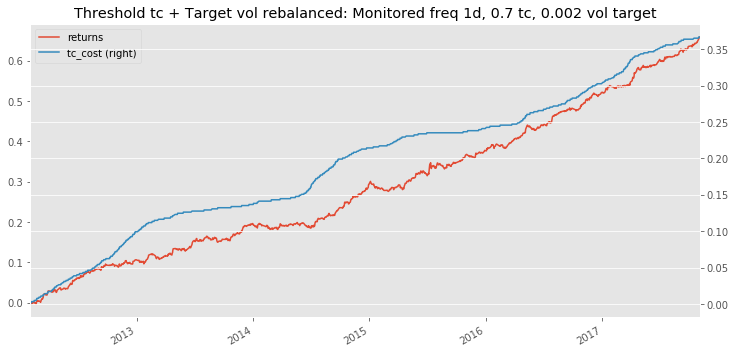

In [232]:
ret_df3[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                             title='Threshold tc + Target vol rebalanced: Monitored freq {0}, {1} tc, {2} vol target'.format(freq,
                                                                                                                                             turn_over_threshold,
                                                                                                                                             target_vol),
                                             secondary_y='tc_cost')

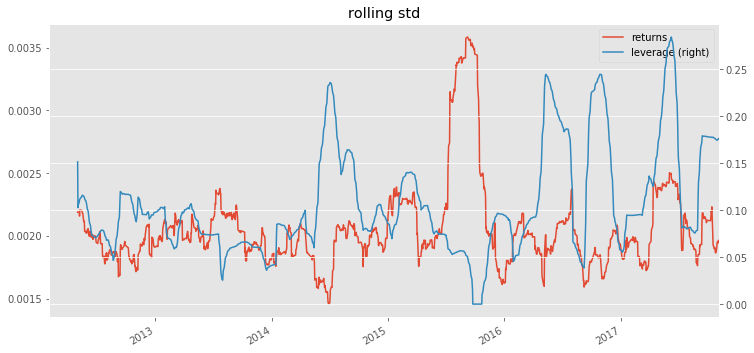

In [233]:
ret_df3[['returns', 'leverage']].rolling(window=60).std().plot(figsize=(12, 6), title='rolling std', secondary_y='leverage')

In [234]:
ret_atfer_tc = ret_df3.returns - ret_df3.tc_cost
print("sharp: ", ret_atfer_tc.mean() / ret_atfer_tc.std() * np.sqrt(252))

sharp:  1.53034639569


In [235]:
ret_df3.tail()

,leverage,returns,turn_over,tc_cost
2017-10-30,0.756706,0.004698,0.000000,0.000000
2017-10-31,0.684986,0.001833,0.772536,0.001545
2017-11-01,0.684986,0.001583,0.000000,0.000000
2017-11-02,0.684986,0.002921,0.000000,0.000000
2017-11-03,0.684986,0.000171,0.000000,0.000000


# Target Turn Over + Strategy
------------------------

In [236]:
rets = []
turn_overs = []
turn_over_target_base = 0.04
executor = NaiveExecutor()
execution_pipeline = ExecutionPipeline(executors=[executor])
leverags = []
previous_pos = pd.DataFrame()
execution_dates = []
horizon = _map_freq(freq)

for i, value in enumerate(factor_groups):
    date = value[0]
    data = value[1]
    
    # get the latest model
    models = model_df[model_df.index <= date]
    
    if models.empty:
        continue
    
    execution_dates.append(date)
    model = models[-1]
    
    codes = data.code.tolist()
    ref_date = date.strftime('%Y-%m-%d')
    total_data = data.dropna()
    dx_return = None
    risk_exp = total_data[neutralize_risk].values.astype(float)
    industry = total_data.industry.values
    benchmark_w = total_data.weight.values
    
    constraint_exp = total_data[constraint_risk].values
    risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)
    risk_names = constraint_risk + ['total']
    risk_target = risk_exp_expand.T @ benchmark_w
    lbound = np.zeros(len(total_data))
    ubound = 0.01 + benchmark_w

    constraint = Constraints(risk_exp_expand, risk_names)
    for i, name in enumerate(risk_names):
        if name == 'total' or name == 'SIZE':
            constraint.set_constraints(name, lower_bound=risk_target[i], upper_bound=risk_target[i])
        else:
            constraint.set_constraints(name, lower_bound=risk_target[i]*industry_lower, upper_bound=risk_target[i]*industry_upper)
        
    factors_values = factor_processing(total_data[features].values,
                                       pre_process=[winsorize_normal],
                                       post_process=[winsorize_normal])

    er = model.predict(factors_values)
    
    codes = total_data['code'].values
    
    
    if previous_pos.empty:
        current_position = None
        turn_over_target = None
    else:
        previous_pos.set_index('code', inplace=True)
        remained_pos = previous_pos.loc[codes]
        
        remained_pos.fillna(0., inplace=True)
        turn_over_target = turn_over_target_base
        
        current_position = remained_pos.weight.values
    
    try:
        target_pos, _ = er_portfolio_analysis(er,
                                              industry,
                                              dx_return,
                                              constraint,
                                              False,
                                              benchmark_w,
                                              current_position=current_position,
                                              turn_over_target=turn_over_target)
    except ValueError:
        print('{0} full rebalance'.format(date))
        target_pos, _ = er_portfolio_analysis(er,
                                              industry,
                                              dx_return,
                                              constraint,
                                              False,
                                              benchmark_w)
    
    target_pos['code'] = codes
    
    turn_over, executed_pos = execution_pipeline.execute(target_pos=target_pos)
    
    executed_codes = executed_pos.code.tolist()
    dx_retuns = engine.fetch_dx_return(date, executed_codes, horizon=horizon)
    
    result = pd.merge(executed_pos, total_data, on=['code'], how='inner')
    result = pd.merge(result, dx_retuns, on=['code'])
    leverage = result.weight_x.abs().sum()
    
    ret = (result.weight_x - result.weight_y * leverage / result.weight_y.sum()).values @ result.dx.values
    rets.append(ret)
    leverags.append(executed_pos.weight.abs().sum())
    turn_overs.append(turn_over)
    previous_pos = executed_pos
    
    print('{0} is finished: {1}'.format(date, turn_over))

2012-02-02 00:00:00 is finished: 0.9763
2012-02-03 00:00:00 is finished: 0.040000000000000084
2012-02-06 00:00:00 is finished: 0.04000000000000012
2012-02-07 00:00:00 is finished: 0.040000000000000105
2012-02-08 00:00:00 is finished: 0.040000000000000126
2012-02-09 00:00:00 is finished: 0.040000000000000105
2012-02-10 00:00:00 is finished: 0.04000000000000008
2012-02-13 00:00:00 is finished: 0.040000000000000105
2012-02-14 00:00:00 is finished: 0.04000000000000015
2012-02-15 00:00:00 is finished: 0.04000000000000012
2012-02-16 00:00:00 is finished: 0.04000000000000015
2012-02-17 00:00:00 is finished: 0.04000000000000015
2012-02-20 00:00:00 is finished: 0.04000000000000011
2012-02-21 00:00:00 is finished: 0.040000000000000105
2012-02-22 00:00:00 is finished: 0.04000000000000009
2012-02-23 00:00:00 is finished: 0.04000000000000012
2012-02-24 00:00:00 is finished: 0.040000000000000105
2012-02-27 00:00:00 is finished: 0.04000000000000014
2012-02-28 00:00:00 is finished: 0.05130000000000014

2012-09-14 00:00:00 is finished: 0.04000000000000008
2012-09-17 00:00:00 is finished: 0.04000000000000012
2012-09-18 00:00:00 is finished: 0.040000000000000105
2012-09-19 00:00:00 is finished: 0.04000000000000015
2012-09-20 00:00:00 is finished: 0.040000000000000126
2012-09-21 00:00:00 is finished: 0.04000000000000014
2012-09-24 00:00:00 is finished: 0.04000000000000009
2012-09-25 00:00:00 is finished: 0.04000000000000011
2012-09-26 00:00:00 is finished: 0.040000000000000105
2012-09-27 00:00:00 is finished: 0.04000000000000009
2012-09-28 00:00:00 is finished: 0.04000000000000005
2012-10-08 00:00:00 is finished: 0.05070000000000011
2012-10-09 00:00:00 is finished: 0.04000000000000013
2012-10-10 00:00:00 is finished: 0.04000000000000012
2012-10-11 00:00:00 is finished: 0.04000000000000013
2012-10-12 00:00:00 is finished: 0.040000000000000105
2012-10-15 00:00:00 is finished: 0.04000000000000009
2012-10-16 00:00:00 is finished: 0.040000000000000105
2012-10-17 00:00:00 is finished: 0.040000

2013-05-13 00:00:00 is finished: 0.040000000000000105
2013-05-14 00:00:00 is finished: 0.04000000000091688
2013-05-15 00:00:00 is finished: 0.04000000000000012
2013-05-16 00:00:00 is finished: 0.04000000000000013
2013-05-17 00:00:00 is finished: 0.04000000000000011
2013-05-20 00:00:00 is finished: 0.04000000000000013
2013-05-21 00:00:00 is finished: 0.04000000000000012
2013-05-22 00:00:00 is finished: 0.04000000000000014
2013-05-23 00:00:00 is finished: 0.040000000000000126
2013-05-24 00:00:00 is finished: 0.04000000000000011
2013-05-27 00:00:00 is finished: 0.040000000000000195
2013-05-28 00:00:00 is finished: 0.051400000000000154
2013-05-29 00:00:00 is finished: 0.040000000000000126
2013-05-30 00:00:00 is finished: 0.040000000000000105
2013-05-31 00:00:00 is finished: 0.04000000000000005
2013-06-03 00:00:00 is finished: 0.0400000000000001
2013-06-04 00:00:00 is finished: 0.04000000000000008
2013-06-05 00:00:00 is finished: 0.040000000000000105
2013-06-06 00:00:00 is finished: 0.04000

2013-12-27 00:00:00 is finished: 0.04000000000000011
2013-12-30 00:00:00 is finished: 0.040000000000000126
2013-12-31 00:00:00 full rebalance
2013-12-31 00:00:00 is finished: 0.6465750905210536
2014-01-02 00:00:00 is finished: 0.0400000000000001
2014-01-03 00:00:00 is finished: 0.040000000000000105
2014-01-06 00:00:00 is finished: 0.04000000000000013
2014-01-07 00:00:00 is finished: 0.0400000000000001
2014-01-08 00:00:00 is finished: 0.04000000000000011
2014-01-09 00:00:00 is finished: 0.040000000000000105
2014-01-10 00:00:00 is finished: 0.040000000000000105
2014-01-13 00:00:00 is finished: 0.04000000000000006
2014-01-14 00:00:00 is finished: 0.040000000000000105
2014-01-15 00:00:00 is finished: 0.04000000000000012
2014-01-16 00:00:00 is finished: 0.04000000000000013
2014-01-17 00:00:00 is finished: 0.0400000000000001
2014-01-20 00:00:00 is finished: 0.04000000000000013
2014-01-21 00:00:00 is finished: 0.040000000000000126
2014-01-22 00:00:00 is finished: 0.040000000000000153
2014-01-

2014-08-13 00:00:00 is finished: 0.040000000000000084
2014-08-14 00:00:00 is finished: 0.04000000000000008
2014-08-15 00:00:00 is finished: 0.04000000000000008
2014-08-18 00:00:00 is finished: 0.04000000000000011
2014-08-19 00:00:00 is finished: 0.04000000000000012
2014-08-20 00:00:00 is finished: 0.040000000000000126
2014-08-21 00:00:00 is finished: 0.0400000000000001
2014-08-22 00:00:00 is finished: 0.040000000000000153
2014-08-25 00:00:00 is finished: 0.04000000000000015
2014-08-26 00:00:00 is finished: 0.040000000000000105
2014-08-27 00:00:00 is finished: 0.04000000000000014
2014-08-28 00:00:00 is finished: 0.04000000000000009
2014-08-29 00:00:00 is finished: 0.04000000000000008
2014-09-01 00:00:00 is finished: 0.04000000000000006
2014-09-02 00:00:00 is finished: 0.04000000000000013
2014-09-03 00:00:00 is finished: 0.04000000000000008
2014-09-04 00:00:00 is finished: 0.040000000000000105
2014-09-05 00:00:00 is finished: 0.04000000000000015
2014-09-09 00:00:00 is finished: 0.0400000

2015-04-02 00:00:00 is finished: 0.04000000000000009
2015-04-03 00:00:00 is finished: 0.04000000000000012
2015-04-07 00:00:00 is finished: 0.04000000000000012
2015-04-08 00:00:00 is finished: 0.040000000000000105
2015-04-09 00:00:00 is finished: 0.040000000000000084
2015-04-10 00:00:00 is finished: 0.04000000000000008
2015-04-13 00:00:00 is finished: 0.04000000000000012
2015-04-14 00:00:00 is finished: 0.0400000000000001
2015-04-15 00:00:00 is finished: 0.040000000000000105
2015-04-16 00:00:00 is finished: 0.04000000000000012
2015-04-17 00:00:00 is finished: 0.040000000000000174
2015-04-20 00:00:00 is finished: 0.040000000000000105
2015-04-21 00:00:00 is finished: 0.04000000000000012
2015-04-22 00:00:00 is finished: 0.04000000000000009
2015-04-23 00:00:00 is finished: 0.040000000000000084
2015-04-24 00:00:00 is finished: 0.04000000000000013
2015-04-27 00:00:00 is finished: 0.040000000000000105
2015-04-28 00:00:00 is finished: 0.040000000000000105
2015-04-29 00:00:00 is finished: 0.0400

2015-11-17 00:00:00 is finished: 0.04000000000000009
2015-11-18 00:00:00 is finished: 0.04000000000000011
2015-11-19 00:00:00 is finished: 0.040000000000000105
2015-11-20 00:00:00 is finished: 0.04000000000000015
2015-11-23 00:00:00 is finished: 0.04000000000000012
2015-11-24 00:00:00 is finished: 0.04000000000000011
2015-11-25 00:00:00 is finished: 0.04000000000000015
2015-11-26 00:00:00 is finished: 0.040000000000000195
2015-11-27 00:00:00 is finished: 0.04000000000000016
2015-11-30 00:00:00 full rebalance
2015-11-30 00:00:00 is finished: 0.4764608980072471
2015-12-01 00:00:00 is finished: 0.04000000000000012
2015-12-02 00:00:00 is finished: 0.040000000000000126
2015-12-03 00:00:00 is finished: 0.04000000000000012
2015-12-04 00:00:00 is finished: 0.04000000000000012
2015-12-07 00:00:00 is finished: 0.0400000000000001
2015-12-08 00:00:00 is finished: 0.04000000000000011
2015-12-09 00:00:00 is finished: 0.040000000000000105
2015-12-10 00:00:00 is finished: 0.040000000000000105
2015-12-

2016-07-01 00:00:00 is finished: 0.0400000000000001
2016-07-04 00:00:00 is finished: 0.040000000000000084
2016-07-05 00:00:00 is finished: 0.040000000000000105
2016-07-06 00:00:00 is finished: 0.04000000000000009
2016-07-07 00:00:00 is finished: 0.04000000000000012
2016-07-08 00:00:00 is finished: 0.040000000000000126
2016-07-11 00:00:00 is finished: 0.04000000000000012
2016-07-12 00:00:00 is finished: 0.04000000000000012
2016-07-13 00:00:00 is finished: 0.04000000000000013
2016-07-14 00:00:00 is finished: 0.040000000000000105
2016-07-15 00:00:00 is finished: 0.04000000000000009
2016-07-18 00:00:00 is finished: 0.04000000000000012
2016-07-19 00:00:00 is finished: 0.04000000000000012
2016-07-20 00:00:00 is finished: 0.040000000000000195
2016-07-21 00:00:00 is finished: 0.04000000000000015
2016-07-22 00:00:00 is finished: 0.04000000000000013
2016-07-25 00:00:00 is finished: 0.040000000000000084
2016-07-26 00:00:00 is finished: 0.0400000000000001
2016-07-27 00:00:00 is finished: 0.0400000

2017-02-22 00:00:00 is finished: 0.04000000000000012
2017-02-23 00:00:00 is finished: 0.04000000000000012
2017-02-24 00:00:00 is finished: 0.040000000000000015
2017-02-27 00:00:00 is finished: 0.04000000000000012
2017-02-28 00:00:00 is finished: 0.04000000000000001
2017-03-01 00:00:00 is finished: 0.04000000000000008
2017-03-02 00:00:00 is finished: 0.04000000000000012
2017-03-03 00:00:00 is finished: 0.04000000000000009
2017-03-06 00:00:00 is finished: 0.04000000000000014
2017-03-07 00:00:00 is finished: 0.04000000000000012
2017-03-08 00:00:00 is finished: 0.04000000000000012
2017-03-09 00:00:00 is finished: 0.04000000000000011
2017-03-10 00:00:00 is finished: 0.04000000000000008
2017-03-13 00:00:00 is finished: 0.04000000000000013
2017-03-14 00:00:00 is finished: 0.04000000000000013
2017-03-15 00:00:00 is finished: 0.040000000000000105
2017-03-16 00:00:00 is finished: 0.040000000000000126
2017-03-17 00:00:00 is finished: 0.04000000000000014
2017-03-20 00:00:00 is finished: 0.04000000

2017-10-09 00:00:00 is finished: 0.04000000000000013
2017-10-10 00:00:00 is finished: 0.04000000000000009
2017-10-11 00:00:00 is finished: 0.04000000000000012
2017-10-12 00:00:00 is finished: 0.04000000000000008
2017-10-13 00:00:00 is finished: 0.04000000000000009
2017-10-16 00:00:00 is finished: 0.04000000000000012
2017-10-17 00:00:00 is finished: 0.040000000000000126
2017-10-18 00:00:00 is finished: 0.04000000000000009
2017-10-19 00:00:00 is finished: 0.04000000000000014
2017-10-20 00:00:00 is finished: 0.04000000000000011
2017-10-23 00:00:00 is finished: 0.04000000000000011
2017-10-24 00:00:00 is finished: 0.04000000000000012
2017-10-25 00:00:00 is finished: 0.040000000000000105
2017-10-26 00:00:00 is finished: 0.04000000000000014
2017-10-27 00:00:00 is finished: 0.04000000000000013
2017-10-30 00:00:00 is finished: 0.040000000000000126
2017-10-31 00:00:00 is finished: 0.04000000000000002
2017-11-01 00:00:00 is finished: 0.040000000000000105
2017-11-02 00:00:00 is finished: 0.0400000

In [237]:
ret_df4 = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=execution_dates)
ret_df4.loc[advanceDateByCalendar('china.sse', dates[-1], freq)] = 0.
ret_df4 = ret_df4.shift(1)
ret_df4.iloc[0] = 0.
ret_df4['tc_cost'] = ret_df4.turn_over * 0.002

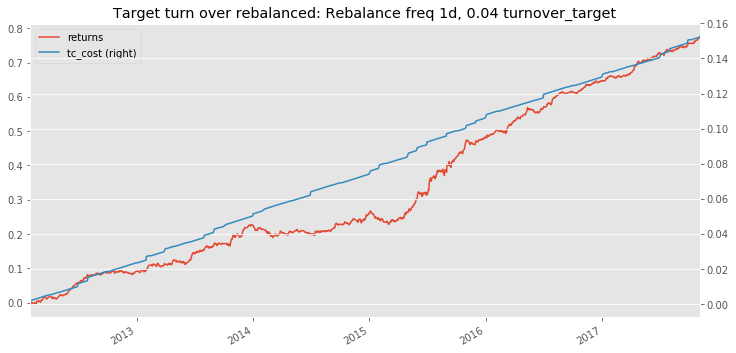

In [238]:
ret_df4[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                             title='Target turn over rebalanced: Rebalance freq {0}, {1} turnover_target'.format(freq,
                                                                                                                                 turn_over_target_base),
                                             secondary_y='tc_cost')

In [239]:
ret_atfer_tc = ret_df4.returns - ret_df4.tc_cost
print("sharp: ", ret_atfer_tc.mean() / ret_atfer_tc.std() * np.sqrt(252))

sharp:  2.7172844153


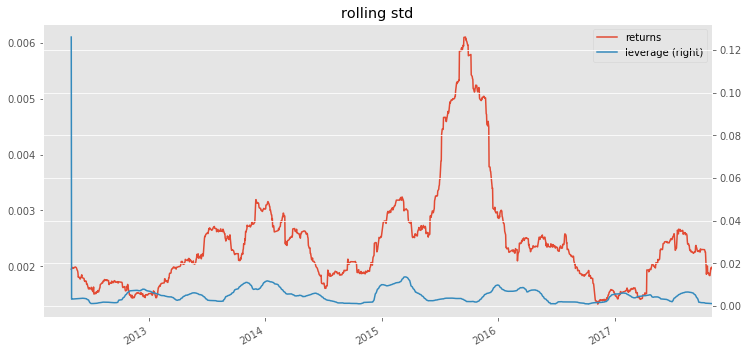

In [240]:
ret_df4[['returns', 'leverage']].rolling(window=60).std().plot(figsize=(12, 6), title='rolling std', secondary_y='leverage')